In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.set_cmap("viridis")

import numpy as np
import theano

In [2]:
from carl.distributions import Join
from carl.distributions import Mixture
from carl.distributions import Normal
from carl.distributions import Exponential
from carl.distributions import LinearTransform
from sklearn.datasets import make_sparse_spd_matrix

# Parameters
true_A = 1.
true_B = -1.
A = theano.shared(true_A, name="A")
B = theano.shared(true_B, name="B")

# Build simulator
R = make_sparse_spd_matrix(5, alpha=0.5, random_state=7)

p0 = LinearTransform(Join(components=[
        Normal(mu=A, sigma=1),
        Normal(mu=B, sigma=3),
        Mixture(components=[Normal(mu=-2, sigma=1),
                            Normal(mu=2, sigma=0.5)]),
        Exponential(inverse_scale=3.0),
        Exponential(inverse_scale=0.5)]), R)

X_true = p0.rvs(20000) 

In [3]:
# Projection operator
print(R)

[[ 1.31229955  0.10499961  0.48310515 -0.3249938  -0.26387927]
 [ 0.10499961  1.15833058 -0.55865473  0.25275522 -0.39790775]
 [ 0.48310515 -0.55865473  2.25874579 -0.52087938 -0.39271231]
 [-0.3249938   0.25275522 -0.52087938  1.4034925  -0.63521059]
 [-0.26387927 -0.39790775 -0.39271231 -0.63521059  1.        ]]


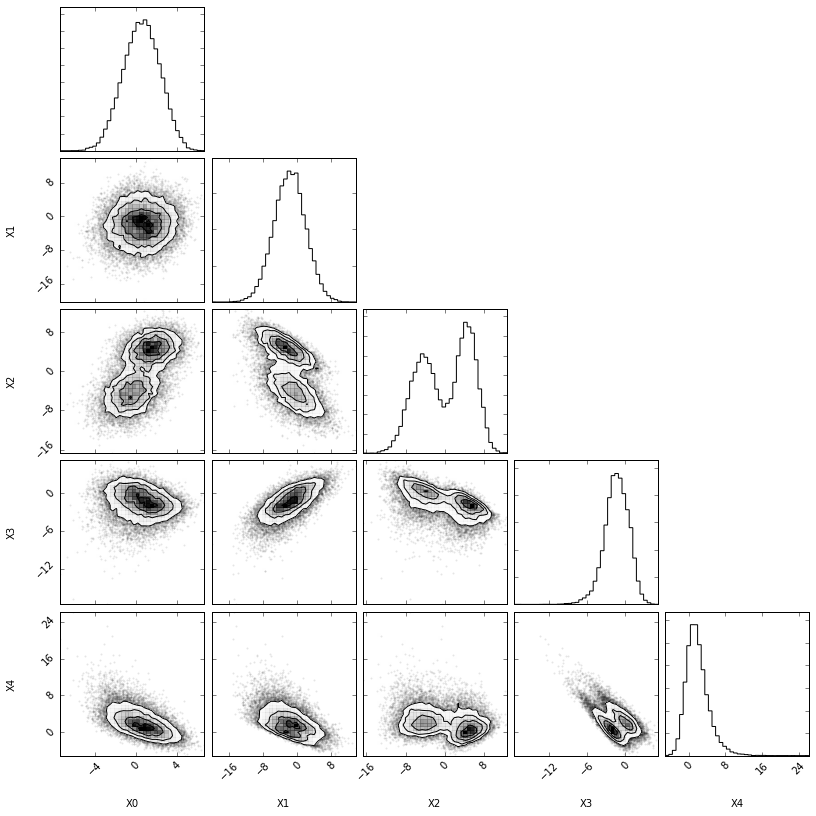

In [4]:
import corner
fig = corner.corner(X_true, bins=40, labels=["X0", "X1", "X2", "X3", "X4"])

In [5]:
from carl.learning import as_classifier
from carl.learning import make_parameterized_classification
from carl.learning import ParameterizedClassifier
from sklearn.neural_network import MLPRegressor
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

# Define p1 at fixed value theta1 := (A=0,B=0)
p1 = LinearTransform(Join(components=[
        Normal(mu=0, sigma=1),
        Normal(mu=0, sigma=3),
        Mixture(components=[Normal(mu=-2, sigma=1),
                            Normal(mu=2, sigma=0.5)]),
        Exponential(inverse_scale=3.0),
        Exponential(inverse_scale=0.5)]), R)

# Build classification data
X, y = make_parameterized_classification(
    p0, p1,
    1000000, 
    [(A, np.linspace(-3, 3, num=30)), 
     (B, np.linspace(-3, 3, num=30))])

# Train parameterized classifier
clf = ParameterizedClassifier(
    make_pipeline(StandardScaler(), 
                  as_classifier(MLPRegressor(learning_rate="adaptive", 
                                             hidden_layer_sizes=(40, 40),
                                             tol=1e-6,
                                             random_state=1))),
    [A, B])
clf.fit(X, y)

//anaconda/envs/carl-notebooks/lib/python3.5/site-packages/sklearn/cross_validation.py:43: DeprecationWarning: This module has been deprecated in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


ParameterizedClassifier(base_estimator=Pipeline(steps=[('standardscaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('wrapper', Wrapper(base_estimator=MLPRegressor(activation='relu', algorithm='adam', alpha=0.0001,
       batch_size=200, beta_1=0.9, beta_2=0.999, early_stopping=False,
       epsilon=1e-08, hidden_layer_sizes=(40,...
       shuffle=True, tol=1e-06, validation_fraction=0.1, verbose=False,
       warm_start=False)))]),
            params=[A, B])

In [7]:
from carl.learning import CalibratedClassifierCV
from carl.ratios import ClassifierRatio

def vectorize(func):
    def wrapper(X):
        v = np.zeros(len(X))
        
        for i, x_i in enumerate(X):
            v[i] = func(x_i)
            
        return v.reshape(-1, 1)
    
    return wrapper

def objective(theta, random_state=0): 
    print(theta)
    
    # Set parameter values   
    A.set_value(theta[0])
    B.set_value(theta[1])

    # Fit ratio
    ratio = ClassifierRatio(CalibratedClassifierCV(
        base_estimator=clf, 
        cv="prefit",  # keep the pre-trained classifier
        method="isotonic"))
    ratio.fit(numerator=p0, denominator=p1, n_samples=10000)

    # Evaluate log-likelihood ratio
    r = ratio.predict(X_true, log=True)
    value = -np.mean(r[np.isfinite(r)])

    return value

In [8]:
from GPyOpt.methods import BayesianOptimization
solver = BayesianOptimization(vectorize(objective), [(-3, 3), (-3, 3)])
solver.run_optimization(max_iter=50, true_gradients=False)

[-0.18456249  0.56759279]
[ 2.67271654  2.9646246 ]
[ 1.39064819  0.96353563]
[ 2.41146038 -1.48343268]
[-2.22840483  1.73935198]
[-0.6540637  -0.55273713]
[ 1.04573619  0.05770953]
[ 1.33386606  0.14844589]
[ 0.54038542 -3.        ]
[ 0.93294431 -0.94474372]
[ 0.90911888 -1.08427179]
[ 1.00372591 -0.86396898]
[ 0.990096   -1.04363227]
[ 0.95155395 -0.82501743]
[ 1.00049705 -1.17716728]
[ 0.92440134 -0.70082357]
[ 0.95374523 -1.11537602]
[ 0.93541351 -0.74952275]
[ 0.93219244 -0.98534478]
[ 0.93524907 -0.7360502 ]
[ 1.11031576 -0.97710251]
[ 0.76878166 -1.25830229]
[ 0.88124843 -0.96744944]
[ 0.91661064 -0.93243287]
[ 0.90922934 -0.81280947]
[ 0.91730203 -0.68402518]
[ 0.94682366 -0.9164009 ]
[ 0.8860643  -0.22488077]
[ 0.90431528 -0.49821416]
[ 0.94626457 -0.74211098]
[ 0.75479578 -0.82194973]
[ 0.90372767 -0.96877415]
[ 0.91960847 -0.99277572]
[ 0.78276422 -0.37852595]
[ 0.98384997 -1.42718927]
[ 0.30926077  3.        ]
[ 0.91659694 -1.07773577]
[ 0.91488526 -1.05636759]
[ 0.92854922

1

In [15]:
est_MLE = solver.x_opt
print("Estimated MLE =", est_MLE)

Estimated MLE = [ 0.95998307 -0.86858641]


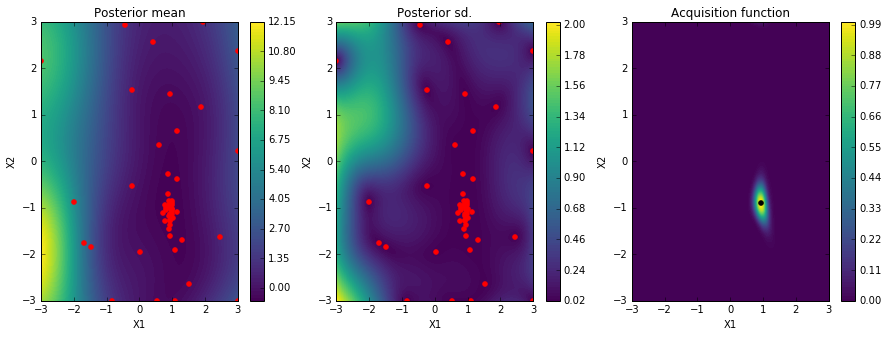

In [9]:
solver.plot_acquisition()

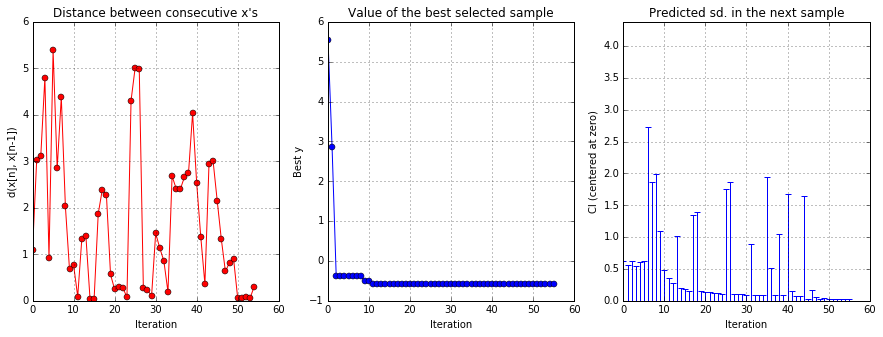

In [10]:
solver.plot_convergence()

In [51]:
from scipy.optimize import minimize

def true_objective(x):
    A.set_value(x[0])
    B.set_value(x[1])
    return (p0.nnlf(X_true) - p1.nnlf(X_true)).mean()

r = minimize(true_objective, x0=[0, 0])
true_MLE = r.x

print("True MLE =", true_MLE)

True MLE = [ 1.0063273  -1.01266564]


In [62]:
A.set_value(true_A)
B.set_value(true_B)

As = np.linspace(-3, 3, 100)
Bs = np.linspace(-3, 3, 100)
AA, BB = np.meshgrid(As, Bs)
X = np.hstack((AA.reshape(-1, 1),
               BB.reshape(-1, 1)))

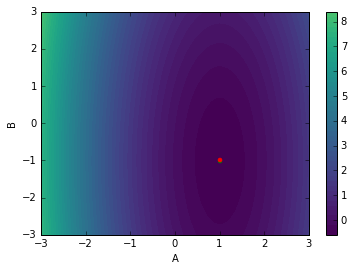

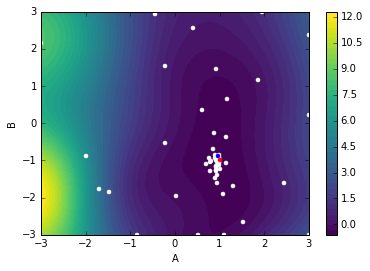

In [96]:
# True contours
true_contours = np.zeros(len(X))
i = 0
for a in As:
    A.set_value(a)
    
    for b in Bs:
        B.set_value(b)
        true_contours[i] = (p0.nnlf(X_true) - p1.nnlf(X_true)).mean()
        i += 1
        
plt.contourf(As, Bs, true_contours.reshape(AA.shape).T, 50, vmin=-0.5, vmax=12)
plt.colorbar()
plt.xlabel("A")
plt.ylabel("B")
plt.plot([true_MLE[0]], [true_MLE[1]], "g.", markersize=8)
plt.plot([true_A], [true_B], "r.", markersize=8)
plt.axis((-3, 3, -3, 3))
plt.savefig("fig5a.pdf")
plt.show()

# Estimated contours
est_contours, _ = solver.model.predict(X)
plt.contourf(As, Bs, est_contours.reshape(AA.shape), 50, vmin=-0.5, vmax=12)
plt.colorbar()
plt.xlabel("A")
plt.ylabel("B")
plt.plot(solver.X[:,0], solver.X[:,1], 'w.', markersize=8)
plt.plot([true_A], [true_B], "r.", markersize=8)
plt.plot([est_MLE[0]], [est_MLE[1]], "b.", markersize=8)
plt.axis((-3, 3, -3, 3))
plt.savefig("fig5b.pdf")
plt.show()